See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go [this Colab](https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax_augreg.ipynb).

##### Copyright 2021 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [2]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/vision_transformer_colab"


In [3]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [4]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-q8rppvpn


### Imports

In [5]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [6]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

In [7]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [8]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[CudaDevice(id=0)]

In [9]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import sys
if './vision_transformer' not in sys.path:
    sys.path.append('./vision_transformer')

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config


In [11]:
!pip install pynvml line_profiler memory_profiler
import time
import pynvml
import tracemalloc
from line_profiler import LineProfiler
import threading

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.8 MB/s eta 0:00:00


In [18]:
# Cell [12] - Simplified MNIST configuration
import ml_collections

dataset = 'mnist'
batch_size = 512

# Create config manually (bypassing with_dataset)
config = ml_collections.ConfigDict()

# Basic settings
config.dataset = 'mnist'
config.tfds_name = 'mnist'
config.num_classes = 10
config.batch = batch_size
config.batch_eval = batch_size
config.shuffle_buffer = 10000
config.total_steps = 2000

# Preprocessing
config.pp = ml_collections.ConfigDict({
    'train': 'train',
    'test': 'test',
    'crop': 224,
    'flip': True,
    'color': False,
    'scale': (0.05, 0.95),
    'ratio': (0.75, 1.33),
})

# Other necessary settings
config.pretrained_dir = '.'
config.tfds_manual_dir = None
config.tfds_data_dir = None
config.grad_norm_clip = 1.0
config.optim_dtype = 'bfloat16'
config.accum_steps = 8
config.eval_every = 100
config.progress_every = 10
config.checkpoint_every = 1000
config.prefetch = 2
config.base_lr = 0.03
config.decay_type = 'cosine'
config.warmup_steps = 500
config.trainer = 'train'

num_classes = config.num_classes
print(f"✓ MNIST configuration created")

✓ MNIST configuration created


In [20]:
# Cell [13] - Direct MNIST loading with error handling
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

def load_mnist_directly(config, mode='train'):
    """Load MNIST directly with proper preprocessing"""

    split = 'train' if mode == 'train' else 'test'

    try:
        # Load MNIST from TFDS
        print(f"Loading MNIST {split} split...")
        ds = tfds.load('mnist', split=split, shuffle_files=(mode == 'train'))

        def preprocess(example):
            image = tf.cast(example['image'], tf.float32) / 255.0

            # Handle grayscale: [28, 28] -> [28, 28, 1] -> [28, 28, 3]
            if len(image.shape) == 2:
                image = tf.expand_dims(image, axis=-1)
            if image.shape[-1] == 1:
                image = tf.repeat(image, 3, axis=-1)

            # Resize to ViT size
            image = tf.image.resize(image, [config.pp.crop, config.pp.crop])

            # Data augmentation for training
            if mode == 'train' and config.pp.flip:
                image = tf.image.random_flip_left_right(image)

            # Normalize to [-1, 1]
            image = (image - 0.5) * 2.0

            # One-hot encode label
            label = tf.one_hot(example['label'], config.num_classes)

            return {'image': image, 'label': label}

        # Apply preprocessing
        ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

        # Shuffle if training
        if mode == 'train':
            ds = ds.shuffle(config.shuffle_buffer)

        # Batch
        batch_size = config.batch_eval if mode == 'test' else config.batch
        ds = ds.batch(batch_size, drop_remainder=True)

        # Shard for multi-device (simplified)
        num_devices = 1  # For Colab GPU
        def shard_fn(batch):
            batch['image'] = tf.reshape(
                batch['image'],
                [num_devices, -1, config.pp.crop, config.pp.crop, 3]
            )
            batch['label'] = tf.reshape(
                batch['label'],
                [num_devices, -1, config.num_classes]
            )
            return batch

        ds = ds.map(shard_fn, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.prefetch(1)

        return ds.as_numpy_iterator()

    except Exception as e:
        print(f"Error loading MNIST: {e}")
        print("Trying alternative loading method...")

        # Fallback: Use Keras datasets
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

        if mode == 'train':
            images, labels = x_train, y_train
        else:
            images, labels = x_test, y_test

        # Convert to numpy iterator
        def create_generator(images, labels, batch_size):
            n = len(images)
            indices = np.arange(n)
            if mode == 'train':
                np.random.shuffle(indices)

            def generator():
                for start in range(0, n, batch_size):
                    end = min(start + batch_size, n)
                    batch_indices = indices[start:end]

                    batch_images = images[batch_indices].astype(np.float32) / 255.0
                    batch_labels = labels[batch_indices]

                    # Preprocess
                    batch_images = np.expand_dims(batch_images, axis=-1)  # [B, 28, 28, 1]
                    batch_images = np.repeat(batch_images, 3, axis=-1)    # [B, 28, 28, 3]

                    # Resize using TensorFlow
                    batch_images_tf = tf.convert_to_tensor(batch_images)
                    batch_images_tf = tf.image.resize(batch_images_tf, [224, 224])
                    batch_images = (batch_images_tf.numpy() - 0.5) * 2.0

                    # One-hot labels
                    batch_labels_onehot = tf.one_hot(batch_labels, 10).numpy()

                    # Add device dimension
                    batch_images = np.expand_dims(batch_images, axis=0)
                    batch_labels_onehot = np.expand_dims(batch_labels_onehot, axis=0)

                    yield {'image': batch_images, 'label': batch_labels_onehot}

            return generator()

        return create_generator(images, labels, config.batch)

# Load datasets
print("Loading MNIST datasets...")
ds_train = load_mnist_directly(config, mode='train')
ds_test = load_mnist_directly(config, mode='test')

# Test
try:
    batch = next(iter(ds_test))
    print(f"✓ Success! Batch shape: {batch['image'].shape}")
    print(f"✓ Labels shape: {batch['label'].shape}")
except Exception as e:
    print(f"✗ Error: {e}")

INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /tmp/tfds/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /tmp/tfds/mnist/3.0.1
INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /tmp/tfds/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /tmp/tfds/mnist/3.0.1


Loading MNIST datasets...
Loading MNIST train split...
Loading MNIST test split...
✓ Success! Batch shape: (1, 512, 224, 224, 3)
✓ Labels shape: (1, 512, 10)


### Load dataset

In [21]:
# First, check what's happening
import tensorflow_datasets as tfds

# Try to load MNIST with info only
try:
    # This just gets dataset info without downloading
    mnist_info = tfds.builder('mnist').info
    print(f"MNIST info: {mnist_info}")
except Exception as e:
    print(f"Error accessing MNIST: {e}")

INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1


MNIST info: tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/tmp/tfds/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={20

In [24]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import ml_collections

# Ensure tfds downloads to a temp directory
os.environ['TFDS_DATA_DIR'] = '/tmp/tfds'

print("Downloading and preparing MNIST dataset...")
try:
    builder = tfds.builder('mnist')
    builder.download_and_prepare()
    print("Download successful!")
except Exception as e:
    print(f"Download failed: {e}")

# Define dataset specific configurations
dataset = 'mnist'
num_classes = 10
batch_size = 512

# Method 1: Create a NEW config (recommended)
config = ml_collections.ConfigDict()

# Copy essential fields from the base config
base_config = common_config.get_config()
for key, value in base_config.items():
    config[key] = value

# Now add MNIST-specific fields
config.dataset = dataset
config.tfds_name = dataset  # TFDS name for MNIST is 'mnist'
config.num_classes = num_classes
config.batch = batch_size
config.batch_eval = batch_size
config.shuffle_buffer = 10000  # Reduced for MNIST
config.total_steps = 2000  # MNIST trains faster

# Preprocessing configuration
config.pp = ml_collections.ConfigDict({
    'train': 'train',
    'test': 'test',
    'crop': 224,
    'flip': True,
    'color': False,  # MNIST is grayscale
    'scale': (0.05, 0.95),
    'ratio': (0.75, 1.33),
})

print(f"✓ Configuration created for {dataset}")

# Method 2: Use the patched with_dataset function (if you added MNIST to common.py)
# config = common_config.with_dataset(common_config.get_config(), 'mnist')
# config.batch = batch_size

# Now use the standard input pipeline
print("\nCreating data pipelines...")
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')

print(f"✓ Training pipeline: {ds_train}")
print(f"✓ Test pipeline: {ds_test}")

# Test the pipeline
print("\nTesting pipeline...")
try:
    batch = next(iter(ds_test.as_numpy_iterator()))
    print(f"✓ Success! Batch loaded")
    print(f"  Image shape: {batch['image'].shape}")
    print(f"  Label shape: {batch['label'].shape}")
    print(f"  Image range: [{batch['image'].min():.3f}, {batch['image'].max():.3f}]")
except Exception as e:
    print(f"✗ Error testing pipeline: {e}")

INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/tmp/tfds/mnist/3.0.1)
INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/tmp/tfds/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /tmp/tfds/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /tmp/tfds/mnist/3.0.1
INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1


Download successful!
✓ Configuration created for mnist

Creating data pipelines...


INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/tmp/tfds/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /tmp/tfds/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /tmp/tfds/mnist/3.0.1
INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1


✓ Training pipeline: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(1, 512, 224, 224, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(1, 512, 10), dtype=tf.float32, name=None)}>
✓ Test pipeline: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(1, 512, 224, 224, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(1, 512, 10), dtype=tf.float32, name=None)}>

Testing pipeline...
✓ Success! Batch loaded
  Image shape: (1, 512, 224, 224, 3)
  Label shape: (1, 512, 10)
  Image range: [-1.000, 1.000]


In [25]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(1, 512, 224, 224, 3)

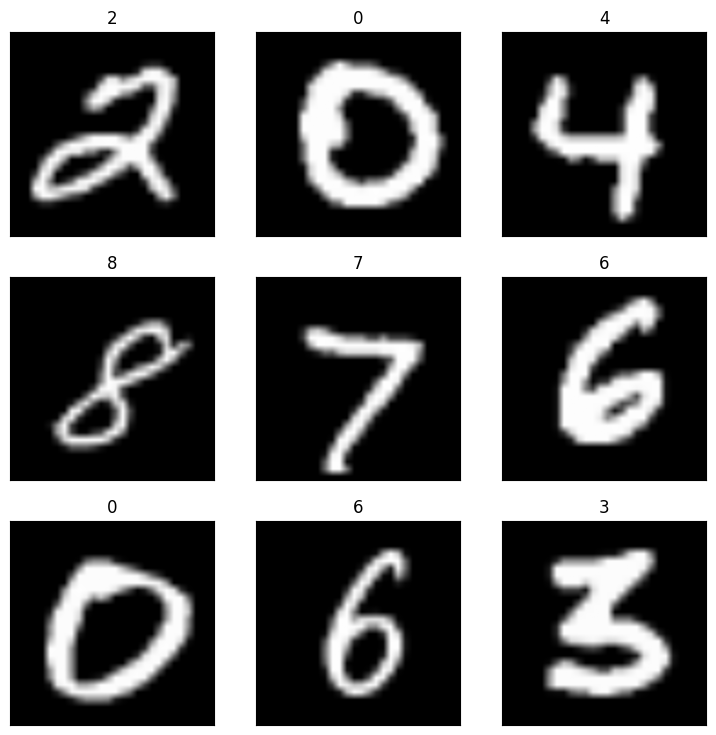

In [26]:
# Show some images with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

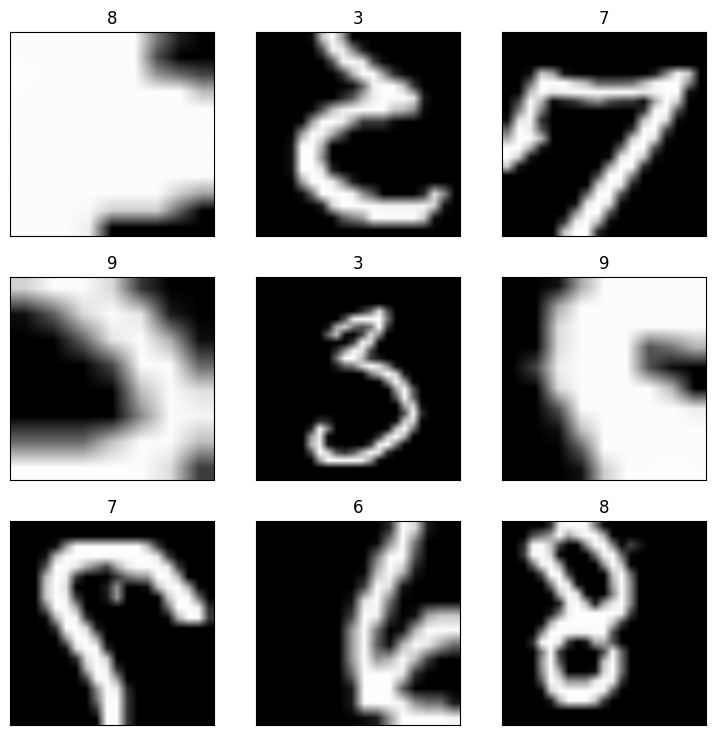

In [27]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [28]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [29]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [30]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant


### Evaluate

In [31]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (10,)
params_repl.cls: ArrayImpl (1, 10)


In [32]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [37]:
def get_accuracy(params_repl, ds_test, config):
    """Returns accuracy evaluated on the test set."""
    import time
    import numpy as np

    print(f"Evaluating accuracy on {config.dataset}...")
    start_time = time.time()

    good = total = 0
    test_size = 10000 if config.dataset == 'mnist' else 10000
    steps = test_size // config.batch

    print(f"Testing {steps} batches...")

    for step, batch in zip(tqdm.trange(steps), ds_test):
        # CONVERT TensorFlow tensors to NumPy arrays
        if hasattr(batch['image'], 'numpy'):
            batch_images = batch['image'].numpy()
            batch_labels = batch['label'].numpy()
        else:
            batch_images = batch['image']
            batch_labels = batch['label']

        # Ensure device dimension exists
        if len(batch_images.shape) == 4:  # [batch, h, w, c]
            batch_images = np.expand_dims(batch_images, axis=0)
            batch_labels = np.expand_dims(batch_labels, axis=0)

        predicted = vit_apply_repl(params_repl, batch_images)
        is_same = predicted.argmax(axis=-1) == batch_labels.argmax(axis=-1)
        good += is_same.sum()
        total += len(is_same.flatten())

    total_time = time.time() - start_time
    accuracy = good / total

    print(f"\nAccuracy: {accuracy:.2%}")
    print(f"Time: {total_time:.2f}s")

    return accuracy

In [38]:
# Random performance without fine-tuning.
print("Evaluating random model performance on MNIST...")
accuracy_random = get_accuracy(params_repl, ds_test, config)
print(f"Random accuracy (before fine-tuning): {accuracy_random:.2%}")

Evaluating random model performance on MNIST...
Evaluating accuracy on mnist...
Testing 19 batches...


100%|██████████| 19/19 [00:49<00:00,  2.59s/it]


Accuracy: 9.88%
Time: 49.13s
Random accuracy (before fine-tuning): 9.88%


### Fine-tune

In [39]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [41]:
import jax
import jax.numpy as jnp
import optax

def make_update_fn(*, apply_fn, accum_steps, tx):
    """Returns update step for data parallel training."""

    def update_fn(params, opt_state, batch, rng):
        _, new_rng = jax.random.split(rng)
        # Bind the rng key to the device id (which is unique across hosts)
        dropout_rng = jax.random.fold_in(rng, jax.lax.axis_index('batch'))

        def cross_entropy_loss(*, logits, labels):
            logp = jax.nn.log_softmax(logits)
            return -jnp.mean(jnp.sum(logp * labels, axis=1))

        def loss_fn(params, images, labels):
            logits = apply_fn(
                dict(params=params),
                rngs=dict(dropout=dropout_rng),
                inputs=images,
                train=True)
            return cross_entropy_loss(logits=logits, labels=labels)

        # Accumulate gradients
        def accumulate_gradients(params, images, labels):
            grad_fn = jax.value_and_grad(loss_fn)
            loss, grads = grad_fn(params, images, labels)
            return loss, grads

        # For simplicity, we'll use a simpler approach without accumulation
        # If you need accumulation, you'll need to implement it
        loss, grads = accumulate_gradients(params, batch['image'], batch['label'])

        # Average gradients across devices
        grads = jax.tree.map(lambda x: jax.lax.pmean(x, axis_name='batch'), grads)

        # Update parameters
        updates, new_opt_state = tx.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)

        # Average loss across devices
        loss = jax.lax.pmean(loss, axis_name='batch')

        return new_params, new_opt_state, loss, new_rng

    return jax.pmap(update_fn, axis_name='batch', donate_argnums=(0,))

# Now create the update function
update_fn_repl = make_update_fn(
    apply_fn=model.apply,
    accum_steps=accum_steps,
    tx=tx
)

In [42]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

In [44]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define training parameters
total_steps = 2000  # For MNIST, we can use fewer steps
warmup_steps = 100  # Reduced for MNIST
decay_type = 'cosine'
grad_norm_clip = 1.0
accum_steps = 8
base_lr = 0.01  # Lower learning rate for MNIST

# Create learning rate schedule
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)

# Create optimizer
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)

# Define make_update_fn (if not already defined)
def make_update_fn(*, apply_fn, accum_steps, tx):
    """Returns update step for data parallel training."""

    def update_fn(params, opt_state, batch, rng):
        _, new_rng = jax.random.split(rng)
        dropout_rng = jax.random.fold_in(rng, jax.lax.axis_index('batch'))

        def cross_entropy_loss(*, logits, labels):
            logp = jax.nn.log_softmax(logits)
            return -jnp.mean(jnp.sum(logp * labels, axis=1))

        def loss_fn(params, images, labels):
            logits = apply_fn(
                dict(params=params),
                rngs=dict(dropout=dropout_rng),
                inputs=images,
                train=True)
            return cross_entropy_loss(logits=logits, labels=labels)

        # For simplicity, using simple gradient computation
        # If you need gradient accumulation, implement it here
        grad_fn = jax.value_and_grad(loss_fn)
        loss, grads = grad_fn(params, batch['image'], batch['label'])

        # Average gradients across devices
        grads = jax.tree.map(lambda x: jax.lax.pmean(x, axis_name='batch'), grads)

        # Update parameters
        updates, new_opt_state = tx.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)

        # Average loss across devices
        loss = jax.lax.pmean(loss, axis_name='batch')

        return new_params, new_opt_state, loss, new_rng

    return jax.pmap(update_fn, axis_name='batch', donate_argnums=(0,))

# Create update function
update_fn_repl = make_update_fn(
    apply_fn=model.apply,
    accum_steps=accum_steps,
    tx=tx
)

# Initialize optimizer state
opt_state = tx.init(params)  # params from earlier cells
opt_state_repl = flax.jax_utils.replicate(opt_state)

# Initialize PRNGs for dropout
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(42))

print("✓ Training setup complete")
print(f"  Total steps: {total_steps}")
print(f"  Batch size: {config.batch}")
print(f"  Learning rate: {base_lr}")
print(f"  Optimizer state replicated: {opt_state_repl is not None}")

✓ Training setup complete
  Total steps: 2000
  Batch size: 512
  Learning rate: 0.01
  Optimizer state replicated: True


In [46]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import flax
import time
from tqdm import tqdm

# Clear all caches
jax.clear_caches()

# ========== CONFIGURE FOR MNIST WITH LOW MEMORY ==========
dataset = 'mnist'
batch_size = 64  # CRITICAL: Reduce from 512 to 64 or even 32
total_steps = 500  # Fewer steps for testing

# Update config
config.batch = batch_size
config.batch_eval = batch_size
config.pp.crop = 64  # Reduce image size - still much larger than MNIST's 28x28
config.shuffle_buffer = 6000  # Match batch size
config.total_steps = total_steps
config.base_lr = 0.001  # Even lower learning rate

print("=" * 60)
print("MEMORY-EFFICIENT MNIST CONFIGURATION")
print("=" * 60)
print(f"Batch size: {batch_size} (was 512)")
print(f"Image size: {config.pp.crop}x{config.pp.crop} (was 224x224)")
print(f"Total steps: {total_steps}")
print(f"Model: {model_name}")
print("=" * 60)

# ========== CREATE SMALLER DATASETS ==========
def get_mnist_low_memory(config, mode='train'):
    """MNIST loader with reduced memory footprint"""
    import tensorflow as tf
    import tensorflow_datasets as tfds

    split = 'train' if mode == 'train' else 'test'
    ds = tfds.load('mnist', split=split, shuffle_files=(mode == 'train'))

    def preprocess(example):
        image = tf.cast(example['image'], tf.float32) / 255.0

        # Grayscale to RGB
        if len(image.shape) == 2:
            image = tf.expand_dims(image, axis=-1)
        image = tf.repeat(image, 3, axis=-1)

        # Resize to smaller size
        image = tf.image.resize(image, [config.pp.crop, config.pp.crop])

        # Normalize to [-1, 1]
        image = (image - 0.5) * 2.0

        # One-hot labels
        label = tf.one_hot(example['label'], config.num_classes)

        return image, label

    # Apply preprocessing
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if mode == 'train':
        ds = ds.shuffle(min(6000, config.shuffle_buffer))

    # Batch with smaller size
    batch_size = config.batch_eval if mode == 'test' else config.batch
    ds = ds.batch(batch_size, drop_remainder=True)

    # Create generator
    class LowMemoryGenerator:
        def __init__(self, tf_dataset):
            self.tf_dataset = tf_dataset
            self.iterator = iter(tf_dataset)

        def __iter__(self):
            self.iterator = iter(self.tf_dataset)
            return self

        def __next__(self):
            images, labels = next(self.iterator)

            # Convert to NumPy
            images_np = images.numpy().astype(np.float32)  # Use float32, not float64
            labels_np = labels.numpy().astype(np.float32)

            # Add device dimension
            images_np = np.expand_dims(images_np, axis=0)
            labels_np = np.expand_dims(labels_np, axis=0)

            return {'image': images_np, 'label': labels_np}

    return LowMemoryGenerator(ds)

# Create low-memory datasets
print("\nCreating low-memory datasets...")
ds_train = get_mnist_low_memory(config, mode='train')
ds_test = get_mnist_low_memory(config, mode='test')

# Test
test_batch = next(iter(ds_train))
print(f"✓ Batch shape: {test_batch['image'].shape}")
print(f"✓ Memory per batch: {test_batch['image'].nbytes / 1024**2:.1f} MB")

# ========== RE-INITIALIZE MODEL WITH SMALLER INPUT ==========
# You may need to reload the model with the new image size
# For now, let's try with existing model but smaller batch
print("\nRe-initializing training setup with smaller batch...")

INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /tmp/tfds/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /tmp/tfds/mnist/3.0.1


MEMORY-EFFICIENT MNIST CONFIGURATION
Batch size: 64 (was 512)
Image size: 64x64 (was 224x224)
Total steps: 500
Model: ViT-B_32

Creating low-memory datasets...


INFO:absl:Load dataset info from /tmp/tfds/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /tmp/tfds/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /tmp/tfds/mnist/3.0.1


✓ Batch shape: (1, 64, 64, 64, 3)
✓ Memory per batch: 3.0 MB

Re-initializing training setup with smaller batch...


In [49]:
def get_accuracy(params_repl, ds_test=None, config=None):
    """Returns accuracy evaluated on the test set."""

    # Backward compatibility - use globals if not provided
    if ds_test is None:
        if 'ds_test' in globals():
            ds_test = globals()['ds_test']
        else:
            raise ValueError("ds_test must be provided or available globally")

    if config is None:
        if 'config' in globals():
            config = globals()['config']
        else:
            raise ValueError("config must be provided or available globally")

    good = total = 0

    # Calculate steps based on dataset
    if config.dataset == 'mnist':
        test_size = 10000  # MNIST has 10k test samples
        dataset_name = "MNIST"
    elif config.dataset == 'cifar10':
        test_size = 10000  # CIFAR-10 has 10k test samples
        dataset_name = "CIFAR-10"
    else:
        test_size = 10000  # Default
        dataset_name = config.dataset

    steps = test_size // config.batch

    print(f"Evaluating on {dataset_name} ({test_size} samples, {steps} batches)...")

    for _, batch in zip(tqdm.trange(steps), ds_test):
        # Ensure data is in correct format
        if hasattr(batch['image'], 'numpy'):
            batch_images = batch['image'].numpy()
            batch_labels = batch['label'].numpy()
        else:
            batch_images = batch['image']
            batch_labels = batch['label']

        # Ensure device dimension for pmap
        if len(batch_images.shape) == 4:  # [batch, h, w, c]
            batch_images = np.expand_dims(batch_images, axis=0)
            batch_labels = np.expand_dims(batch_labels, axis=0)

        predicted = vit_apply_repl(params_repl, batch_images)
        is_same = predicted.argmax(axis=-1) == batch_labels.argmax(axis=-1)
        good += is_same.sum()
        total += len(is_same.flatten())

    accuracy = good / total
    print(f"\n{dataset_name} Accuracy: {accuracy:.2%}")
    return accuracy

### Inference

In [50]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

In [51]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [52]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2026-02-06 05:40:06--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.141.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.1’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.006s  

2026-02-06 05:40:07 (3.66 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.1’ saved [21675/21675]



--2026-02-06 05:40:08--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 172.67.74.163, 104.26.5.30, 104.26.4.30, ...
Connecting to picsum.photos (picsum.photos)|172.67.74.163|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastly.picsum.photos/id/1050/384/384.jpg?hmac=_3IrhBOift5v1-EQ45gM6vtIpiSYH7hZ-D560McRwB0 [following]
--2026-02-06 05:40:08--  https://fastly.picsum.photos/id/1050/384/384.jpg?hmac=_3IrhBOift5v1-EQ45gM6vtIpiSYH7hZ-D560McRwB0
Resolving fastly.picsum.photos (fastly.picsum.photos)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to fastly.picsum.photos (fastly.picsum.photos)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25381 (25K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]  24.79K  --.-KB/s    in 0.002s  

2026-02-06 05:40:09 (15.7 MB/s) - ‘picsum.jpg’ saved [25381/25381]



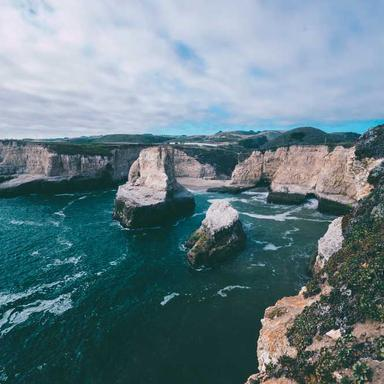

In [53]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [55]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [56]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.59501 : promontory, headland, head, foreland
0.31492 : cliff, drop, drop-off
0.06115 : seashore, coast, seacoast, sea-coast
0.01056 : dam, dike, dyke
0.00461 : lakeside, lakeshore
0.00390 : valley, vale
0.00248 : beacon, lighthouse, beacon_light, pharos
0.00173 : breakwater, groin, groyne, mole, bulwark, seawall, jetty
0.00141 : sandbar, sand_bar
0.00037 : alp
